In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = '..\data\dados_trajeto.csv'

In [3]:
df = pd.read_csv(data_path, sep = ';')

In [4]:
df.head()

,tempo_s,distancia_m
0,10,155.42
1,11,167.37
2,12,179.33
3,13,191.28
4,14,203.24


In [5]:
df['tempo_s'] = df['tempo_s'] - 10
df['distancia_m'] = df['distancia_m'] - 155.42

df.head()

,tempo_s,distancia_m
0,0,0.00
1,1,11.95
2,2,23.91
3,3,35.86
4,4,47.82


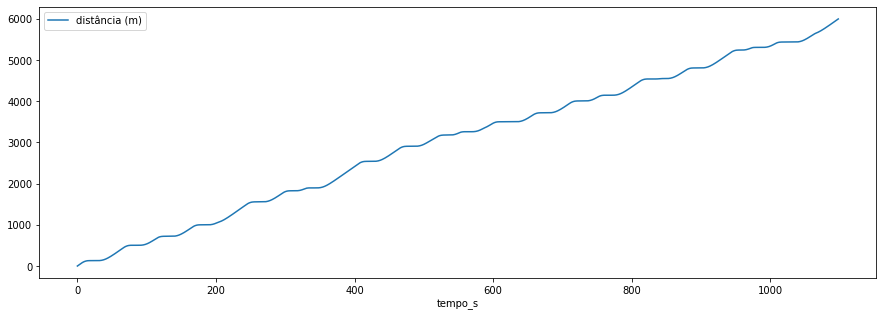

In [6]:
temp = pd.Series(data=df['distancia_m'].values, 
                 index=df['tempo_s'])

temp.plot(figsize=(15, 5), label="distância (m)", legend=True)

plt.show()

In [7]:
delta = df.diff()
delta

,tempo_s,distancia_m
0,NaN,NaN
1,1.0,11.95
2,1.0,11.96
3,1.0,11.95
4,1.0,11.96
...,...,...
1094,1.0,11.87
1095,1.0,11.89
1096,1.0,11.89
1097,1.0,11.91


In [8]:
df['velocidade'] = delta['distancia_m']/delta['tempo_s']

In [9]:
df.head()

,tempo_s,distancia_m,velocidade
0,0,0.00,NaN
1,1,11.95,11.95
2,2,23.91,11.96
3,3,35.86,11.95
4,4,47.82,11.96


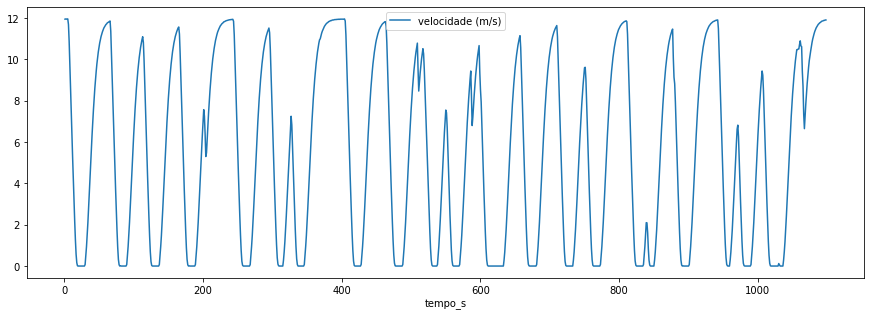

In [10]:
temp = pd.Series(data=df['velocidade'].values, 
                 index=df['tempo_s'])

temp.plot(figsize=(15, 5), label="velocidade (m/s)", legend=True)

plt.show()